<a href="https://colab.research.google.com/github/Sergio-Rodriguez24/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction of Product Sales

<H7>Sergio Rodriguez</H7>



## Project Overview


##Imports


In [303]:
import pandas as pd
import numpy as np
import missingno as msno
from google.colab import drive


## Load and Inspect Data


In [304]:
#import sale prediction
df_sp = pd.read_csv('/content/drive/MyDrive/CodingDojo data import/01-Fundamentals/Week02/Data/sales_predictions_2023.csv')

# look at the info with in the DB
df_sp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [305]:
df_sp.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [306]:
#preview to make sure import correct
df_sp.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Data cleaning


In [307]:
#row/col in df
df_sp.shape

(8523, 12)

In [308]:
df_sp.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [309]:
# of the duplicated rows (including the first)
duplicated_rows_all = df_sp.duplicated(keep=False)
duplicated_rows_all.sum()

0

In [310]:
#identify missing value
null_sum = df_sp.isna().sum()
null_sum[null_sum>0]

Item_Weight    1463
Outlet_Size    2410
dtype: int64

In [311]:
#identify % of missing 
null_percent = null_sum/len(df_sp) *100
null_percent[null_percent>0]

Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64

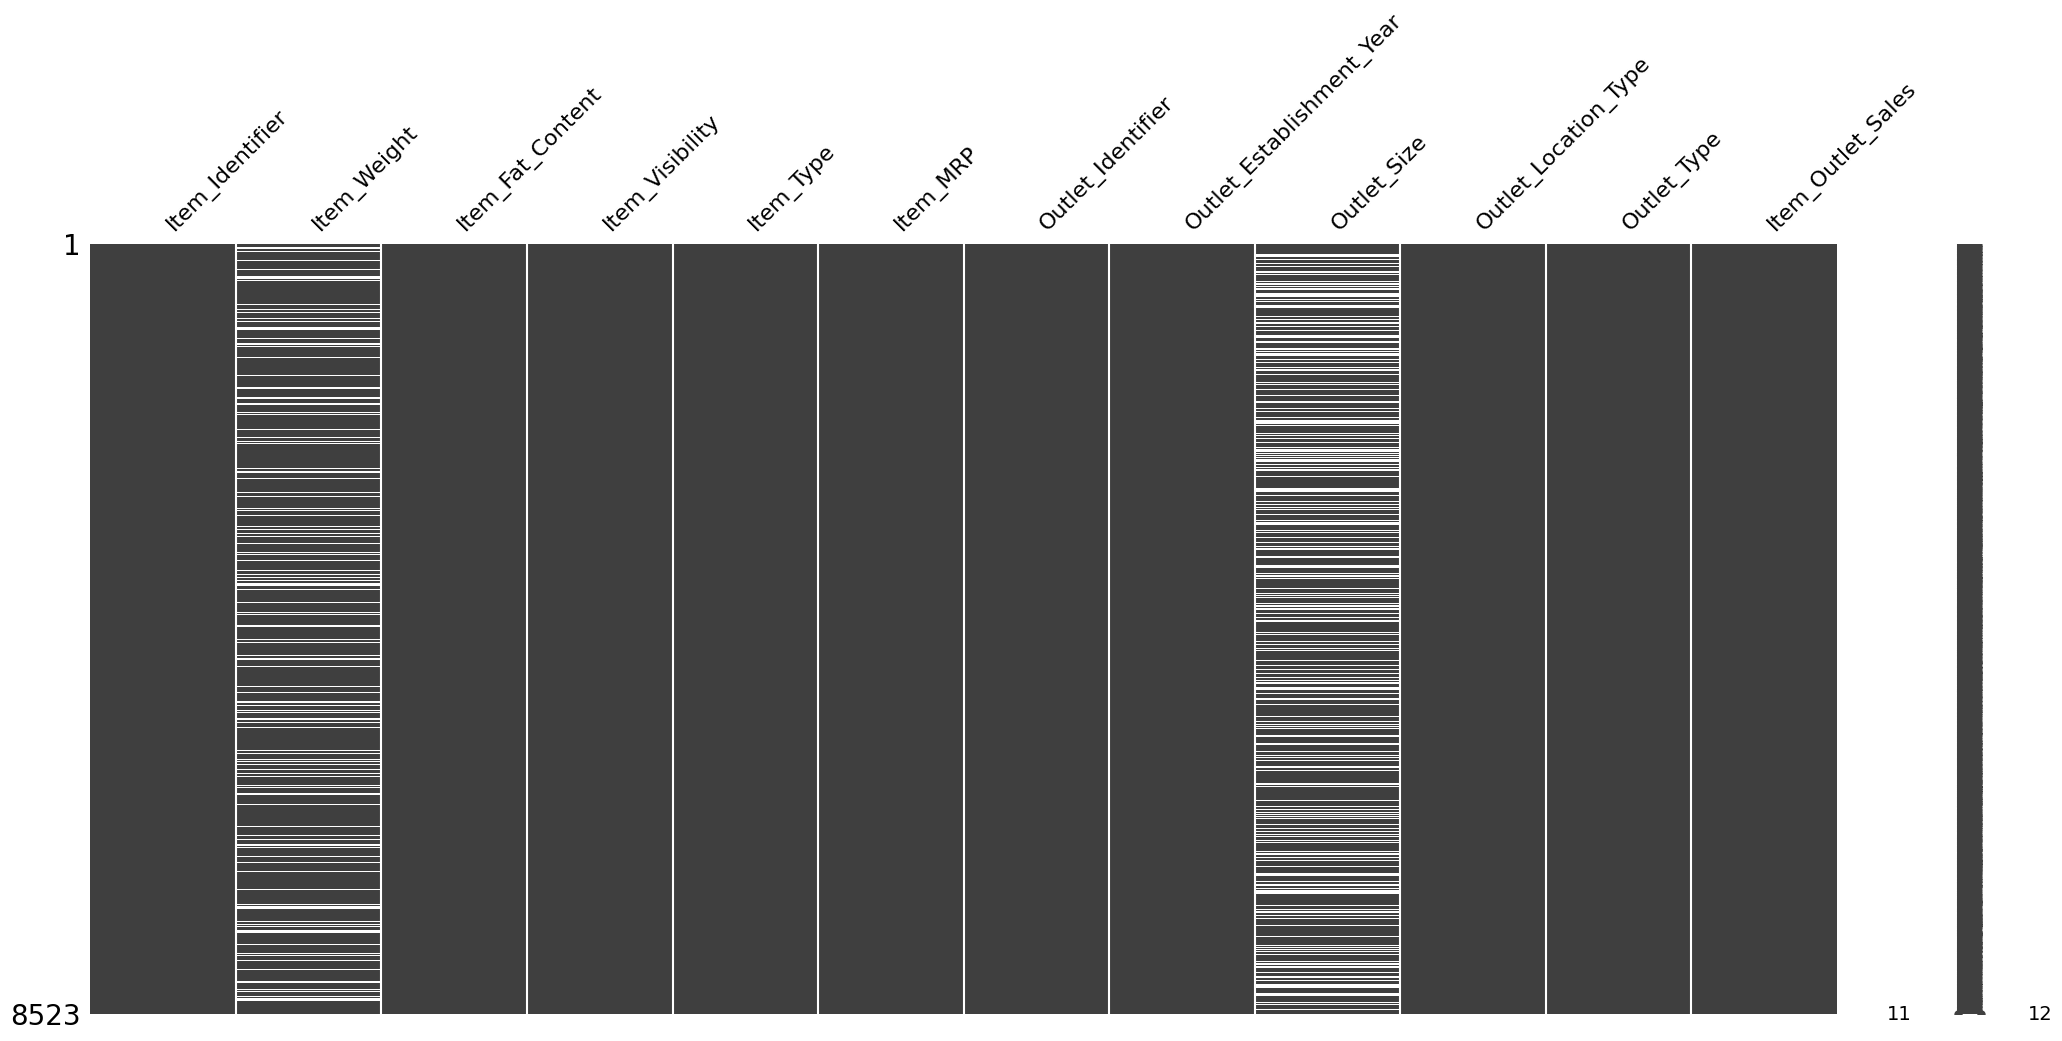

In [312]:
#Visualizing Null Values with missingno
msno.matrix(df_sp);

In [313]:
## Looking for missing value in categorial column
cat_col = df_sp.select_dtypes('object').columns
df_sp [cat_col].isna().sum()

Item_Identifier            0
Item_Fat_Content           0
Item_Type                  0
Outlet_Identifier          0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [314]:
#Place holder value Missing for Outlet_size
df_sp[cat_col] = df_sp[cat_col].fillna('Missing')
#checking 
df_sp[cat_col].isna().sum()

Item_Identifier         0
Item_Fat_Content        0
Item_Type               0
Outlet_Identifier       0
Outlet_Size             0
Outlet_Location_Type    0
Outlet_Type             0
dtype: int64

In [315]:
## Looking for missing value in numerical columns column
num_col = df_sp.select_dtypes('number').columns
df_sp [num_col].isna().sum()

Item_Weight                  1463
Item_Visibility                 0
Item_MRP                        0
Outlet_Establishment_Year       0
Item_Outlet_Sales               0
dtype: int64

In [316]:
# Create a filter for null values
null_item_weight  =df_sp['Item_Weight'].isna()
# Use the filter to display only the rows with null values in item wieght
df_sp[null_item_weight]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


In [317]:
# Changing this value to a null value by using np.nan
df_sp.loc[null_item_weight]=np.nan
#filling value as -1
df_sp['Item_Weight'] =df_sp['Item_Weight'].fillna(-1)
#checkin
df_sp['Item_Weight'].isna().sum()

0

<Axes: >

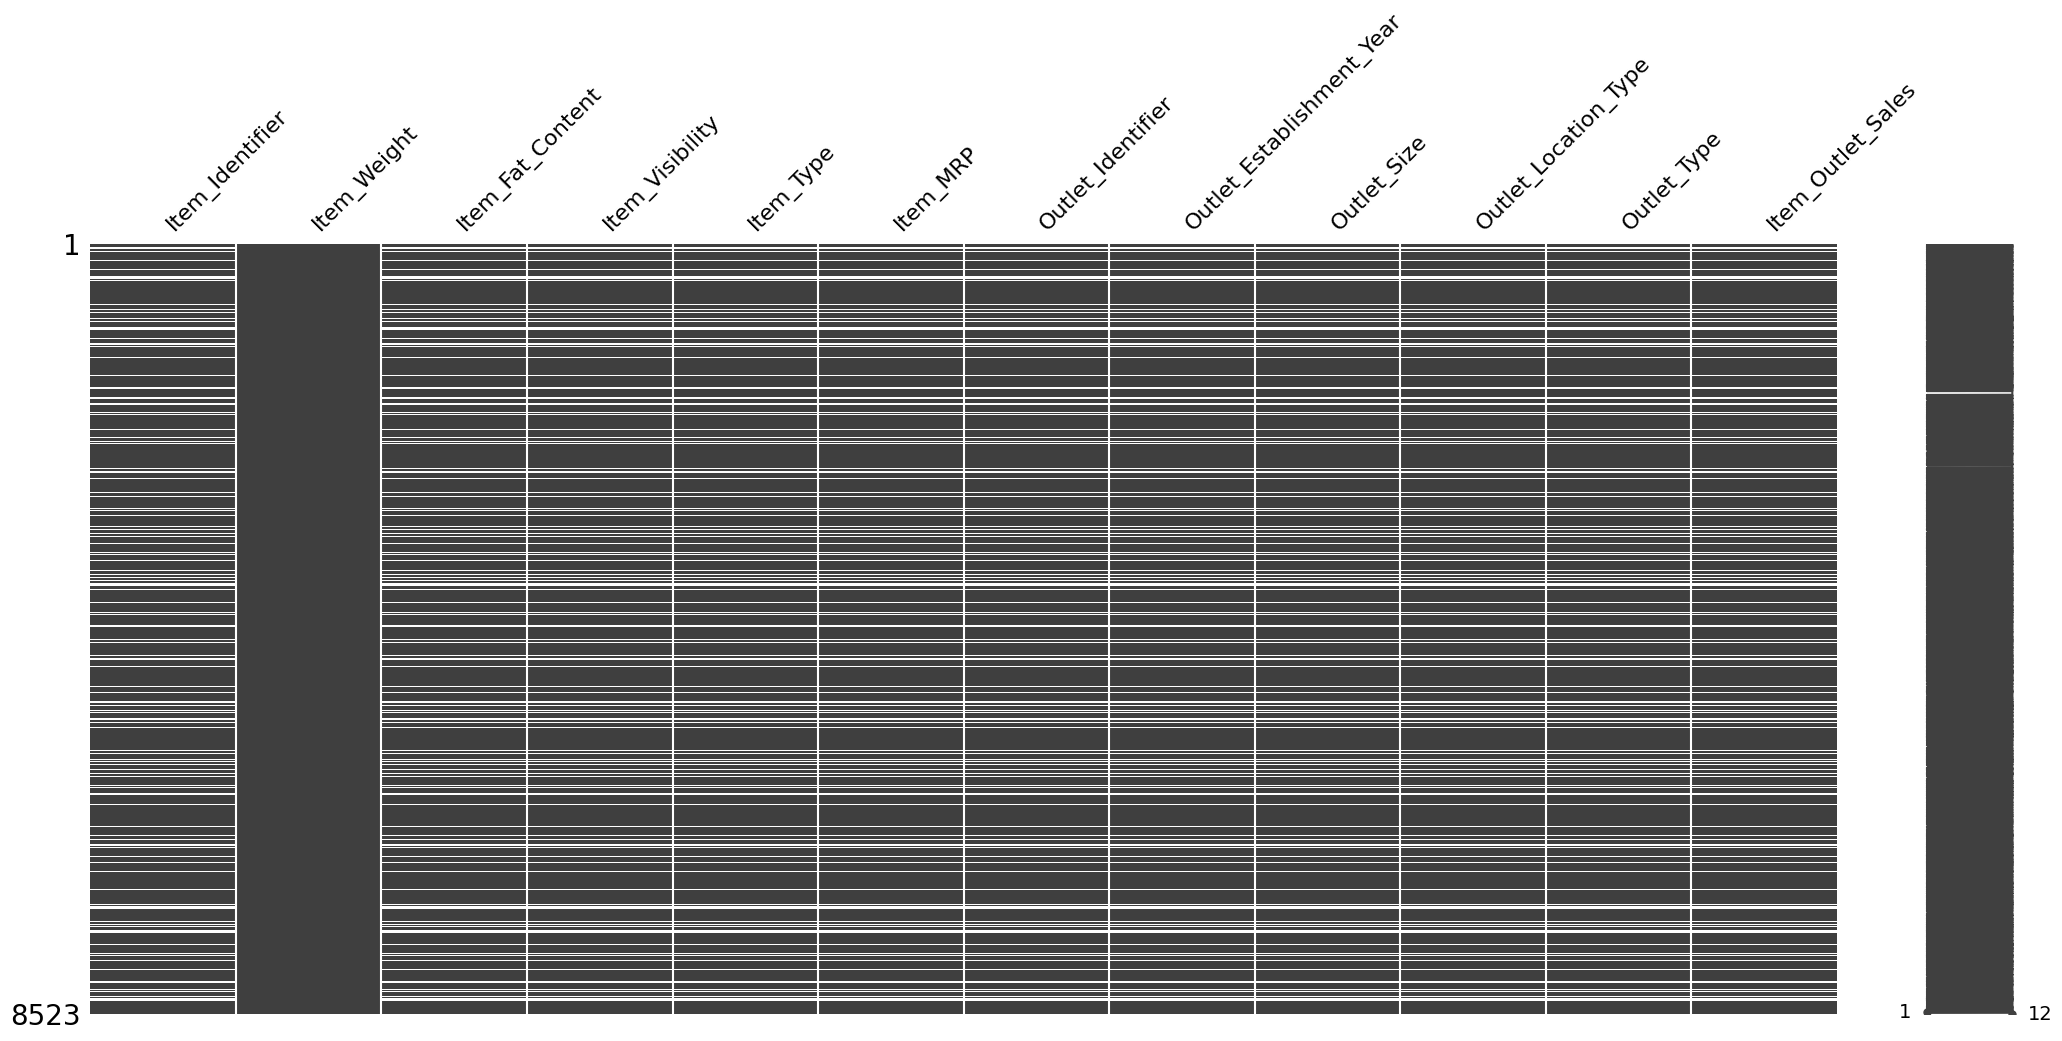

In [318]:
# Confirm no more nulls using using missingno
msno.matrix(df_sp)

In [319]:
# Saving list of object columns 
incon_col = df_sp.select_dtypes('object').columns
incon_col

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [320]:
# Checking for  inconsistent 
for col in incon_col:
  print(f'Value count for {col}')
  print(df_sp[col].value_counts())
  print('\n')

Value count for Item_Identifier
FDF22    8
FDG33    8
DRE49    8
NCY18    8
DRN47    8
        ..
NCS41    1
FDP15    1
NCU29    1
FDH52    1
NCT53    1
Name: Item_Identifier, Length: 1555, dtype: int64


Value count for Item_Fat_Content
Low Fat    4222
Regular    2388
LF          260
reg         106
low fat      84
Name: Item_Fat_Content, dtype: int64


Value count for Item_Type
Fruits and Vegetables    1019
Snack Foods               988
Household                 759
Frozen Foods              718
Dairy                     566
Canned                    539
Baking Goods              536
Health and Hygiene        430
Soft Drinks               374
Meat                      337
Breads                    204
Hard Drinks               183
Others                    137
Starchy Foods             130
Breakfast                  89
Seafood                    51
Name: Item_Type, dtype: int64


Value count for Outlet_Identifier
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
O

In [321]:
# Changed Outlet_Size from high to Large to better fit the rest of the naming 
df_sp['Outlet_Size'] = df_sp['Outlet_Size'].replace({'High':'Large'})
df_sp['Outlet_Size'].value_counts()

Missing    2410
Small      1860
Medium     1858
Large       932
Name: Outlet_Size, dtype: int64

In [322]:
# Changed Item_fat names to match
df_sp ['Item_Fat_Content'] =df_sp ['Item_Fat_Content'].replace({'reg': 'Regular', 'LF' :'Low Fat', 'low fat': 'Low Fat'})
df_sp ['Item_Fat_Content'].value_counts()

Low Fat    4566
Regular    2494
Name: Item_Fat_Content, dtype: int64

In [324]:
df_sp.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,7060.000000,7060.000000,7060.000000,7060.000000
mean,10.478936,0.063963,141.240683,2000.490935,2118.626808
std,6.720742,0.048625,62.411888,6.588984,1533.445842
min,-1.000000,0.000000,31.490000,1987.000000,33.290000
25%,6.650000,0.026768,94.143600,1997.000000,922.798800
50%,11.000000,0.052493,142.729900,2002.000000,1789.670400
75%,16.000000,0.092774,186.024000,2007.000000,2966.139000
max,21.350000,0.311090,266.888400,2009.000000,10256.649000


## Exploratory Data Analysis


## Explanatory Data Analysis

